In [1]:
!pip install pystan==2.19.1.1
!pip install prophet

from sklearn.preprocessing import *
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

import tensorflow as tf
tf.random.set_seed(0)
np.random.seed(0)

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler

     |████████████████████████████████| 71kB 5.6MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 184kB 18.7MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-cp37-none-any.whl size=6640202 sha256=a3ca1863d22bc95f02c0665f3c0d5ef593d68e24de3911e439c437ffaebe4453
  Stored in directory: /root/.cache/pip/wheels/92/1d/02/bc0a91bd3a84e060722075d2b0b68e875e37ec7dc49451d513
Successfully built prophet
ERROR: fbprophet 0.7.1 has requirement cmdstanpy==0.9.5, but you'll have cmdstanpy 0.9.68 which is incompatible.
  Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5


In [2]:
pd.DataFrame.less = lambda df, n=5: df.head(n).append(df.tail(n))

In [3]:
# df_price = pd.read_csv('./bitcoin-price.csv')
# df_news = pd.read_csv('./bitcoin-news.csv',header=None)
# df_price = df_price.iloc[::-1,:].reset_index().drop('index',axis=1)

# df_price['Date'] = pd.to_datetime(df_price['Date'], format='%b %d, %Y')
# df_price = df_price[['Date', 'Price']]
# df_price['Price'] = df_price['Price'].str.replace(',','').astype(float)
# # df['Price'] = np.log(df['Price'])


# df_news['Date'] = pd.to_datetime(df_news[1])

# newscount = list(df_news.iloc[:,2])
# COUNT = []
# for i in range(df_price.shape[0]):
#   date = df_price.iloc[i,0]
#   cnt = newscount.count(date)
#   COUNT.append(cnt)

# DF = df_price.copy()
# DF['Num News'] = COUNT


In [4]:
DF = pd.read_csv('./BTC-data.csv')
DF['Date'] = pd.to_datetime(DF['Date'])
DF['Price'] = np.log(DF['Price'])

DF_TEST = DF.iloc[-520:-34].reset_index().drop('index',axis=1)
DF_TRAIN = DF.iloc[:-520].reset_index().drop('index',axis=1)

# DF[['Date', 'Price', 'log(Price)', 'Num News']].sample(15).sort_values('Date').reset_index()

Epoch 1/100
1554/1554 - 23s - loss: 0.0439 - val_loss: 0.0131
Epoch 2/100
1554/1554 - 3s - loss: 9.7961e-04 - val_loss: 1.0615e-04
Epoch 3/100
1554/1554 - 3s - loss: 6.4007e-05 - val_loss: 1.3524e-05
Epoch 4/100
1554/1554 - 3s - loss: 6.7065e-05 - val_loss: 1.3068e-04
Epoch 5/100
1554/1554 - 3s - loss: 7.5204e-05 - val_loss: 7.8894e-05
Epoch 6/100
1554/1554 - 3s - loss: 6.6532e-05 - val_loss: 1.0781e-05
Epoch 7/100
1554/1554 - 3s - loss: 6.8451e-05 - val_loss: 1.9775e-05
Epoch 8/100
1554/1554 - 3s - loss: 6.4424e-05 - val_loss: 2.8071e-05
Epoch 9/100
1554/1554 - 3s - loss: 6.6063e-05 - val_loss: 4.0537e-05
Epoch 10/100
1554/1554 - 3s - loss: 6.3042e-05 - val_loss: 1.1674e-05
Epoch 11/100
1554/1554 - 3s - loss: 6.7414e-05 - val_loss: 2.3593e-05
Epoch 12/100
1554/1554 - 3s - loss: 5.9433e-05 - val_loss: 3.1221e-05
Epoch 13/100
1554/1554 - 3s - loss: 6.5140e-05 - val_loss: 1.8521e-05
Epoch 14/100
1554/1554 - 3s - loss: 5.9664e-05 - val_loss: 9.6945e-06
Epoch 15/100
1554/1554 - 3s - loss: 

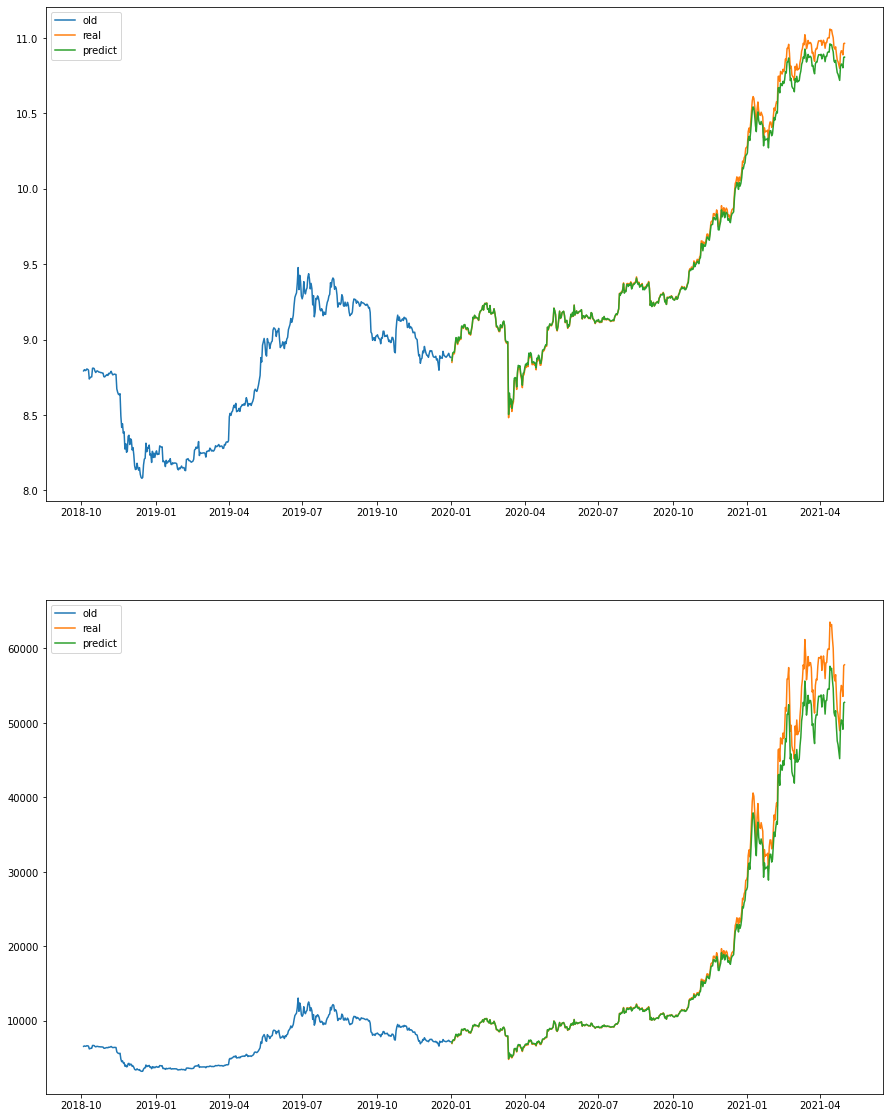

In [5]:
min_max_scaler = MinMaxScaler()
training_set = min_max_scaler.fit_transform(DF_TRAIN['Price'].to_numpy().reshape(-1,1))
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (-1, 1, 1))

testing_set = min_max_scaler.transform(DF_TEST['Price'].to_numpy().reshape(-1,1))
X_test = np.reshape(testing_set, (-1, 1, 1))

num_units = 10
activation_function = 'sigmoid'
optimizer = 'adam'
loss_function = 'mean_squared_error'
batch_size = 2
num_epochs = 100


regressor = Sequential()
regressor.add(LSTM(units = num_units, activation = activation_function, input_shape=(None, 1)))
regressor.add(Dense(units = 5))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = optimizer, loss = loss_function)
regressor.fit(X_train, y_train, batch_size = batch_size, epochs = num_epochs, verbose=2, validation_split=.1)

regpredict = regressor.predict(X_test)
y_pred = min_max_scaler.inverse_transform(regpredict).flatten()
y_test = DF_TEST['Price'].to_numpy().flatten()

rmse = np.sqrt(((y_test - y_pred)**2).sum()/len(y_pred))
print('RMSE(log) = ', rmse)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(15,20))
minold=3000
ax1.plot(DF_TRAIN['Date'][minold:], DF_TRAIN['Price'][minold:], label='old')
ax1.plot(DF_TEST['Date'],DF_TEST['Price'], label='real')
ax1.plot(DF_TEST['Date'], y_pred, label='predict')
ax1.legend()


rmse = np.sqrt(((np.exp(y_test) - np.exp(y_pred))**2).sum()/len(y_pred))
print('RMSE(real) = ', rmse)

ax2.plot(DF_TRAIN['Date'][minold:], np.exp(DF_TRAIN['Price'][minold:]), label='old')
ax2.plot(DF_TEST['Date'],np.exp(DF_TEST['Price']), label='real')
ax2.plot(DF_TEST['Date'], np.exp(y_pred), label='predict')
ax2.legend()

p = 0.05
real = np.exp(y_test)
pred = np.exp(y_pred)

s = np.logical_and((real*(1-p)) <= pred, pred <= (real*(1+p))).sum()
print('Accuracy real',s/len(real))

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


0.6063761212520367
16774.338828332468
Accuracy real 0.059670781893004114


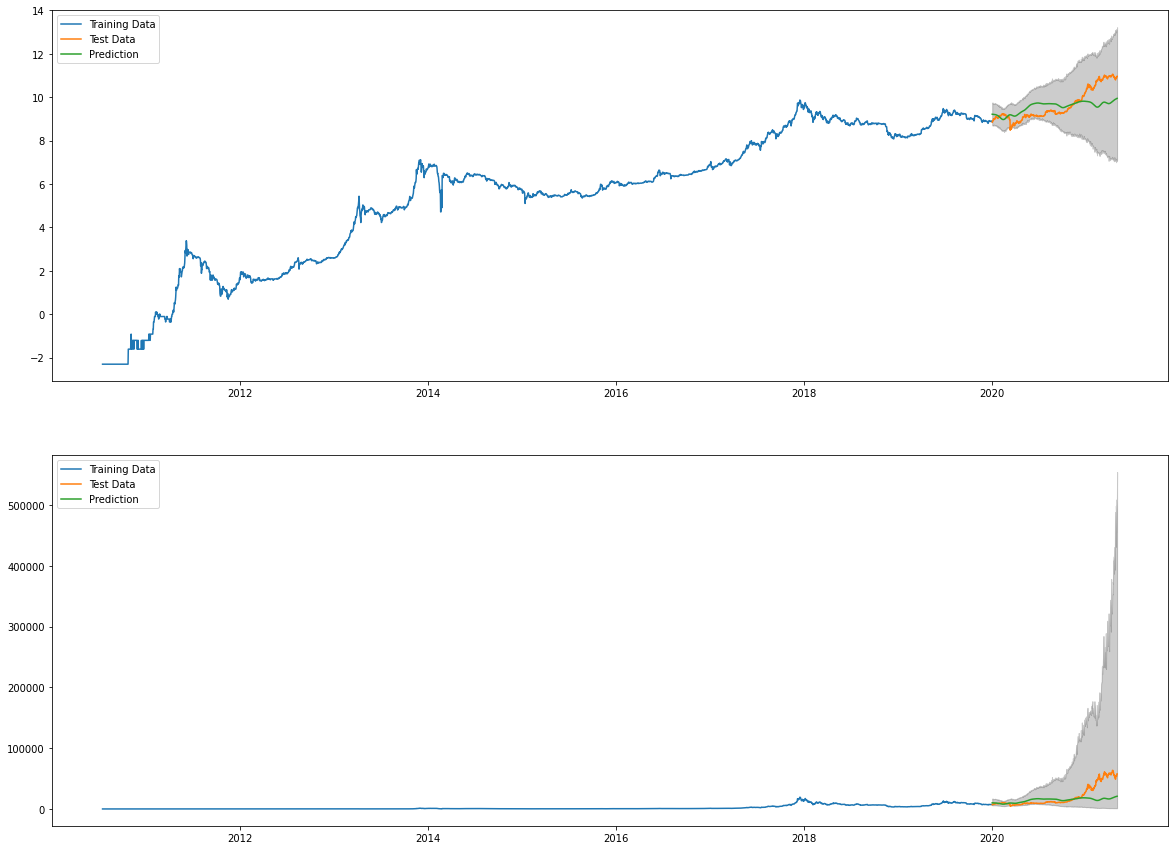

In [6]:
df_train = DF_TRAIN.copy()
df_test = DF_TEST.copy()
df_train.columns = ['ds', 'y', 'news']
df_test.columns = ['ds', 'y', 'news']

# df_train['y'] = np.exp(df_train['y'])
# df_test['y'] = np.exp(df_test['y'])

df_train.drop('news',1,inplace=True)
df_test.drop('news',1,inplace=True)


model = Prophet(
          changepoint_range=0.99, 
          yearly_seasonality='auto', 
          weekly_seasonality=False, 
          daily_seasonality=True,
          seasonality_mode='multiplicative',
          seasonality_prior_scale=.2,    
          n_changepoints=15
    )
model.fit(df_train)
future = df_test[['ds']]
forecast = model.predict(future)
predict = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
predict['real'] = df_test.iloc[:,-1].reset_index().drop('index',axis=1)
rmse = np.sqrt(((predict['real'] - predict['yhat'])**2).sum()/len(predict['real']))
print(rmse)

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20,15))
minold=000

rmse = np.sqrt(((np.exp(predict['real']) - np.exp(predict['yhat']))**2).sum()/len(predict['real']))
print(rmse)

p = 0.05
real = np.exp(predict['real'])
pred = np.exp(predict['yhat'])

s = np.logical_and((real*(1-p)) <= pred, pred <= (real*(1+p))).sum()
print('Accuracy real',s/len(real))

ax1.plot(df_train['ds'][minold:], df_train['y'][minold:], label='Training Data')
ax1.plot(predict['ds'], predict['real'], label='Test Data')
ax1.plot(predict['ds'], predict['yhat'], label='Prediction')
ax1.fill_between(predict['ds'], predict['yhat_lower'], predict['yhat_upper'],color='k',alpha=.2)
ax1.legend(loc='upper left')

ax2.plot(df_train['ds'][minold:], np.exp(df_train['y'][minold:]), label='Training Data')
ax2.plot(predict['ds'], np.exp(predict['real']), label='Test Data')
ax2.plot(predict['ds'], np.exp(predict['yhat']), label='Prediction')
ax2.fill_between(predict['ds'], np.exp(predict['yhat_lower']), np.exp(predict['yhat_upper']),color='k',alpha=.2)
ax2.legend(loc='upper left')

Epoch 1/100
1554/1554 - 6s - loss: 0.0675 - val_loss: 0.0754
Epoch 2/100
1554/1554 - 4s - loss: 0.0189 - val_loss: 0.0168
Epoch 3/100
1554/1554 - 4s - loss: 0.0023 - val_loss: 0.0014
Epoch 4/100
1554/1554 - 4s - loss: 4.1239e-04 - val_loss: 3.8955e-04
Epoch 5/100
1554/1554 - 4s - loss: 2.9206e-04 - val_loss: 3.4881e-04
Epoch 6/100
1554/1554 - 4s - loss: 2.1976e-04 - val_loss: 2.6403e-04
Epoch 7/100
1554/1554 - 4s - loss: 1.7230e-04 - val_loss: 3.3371e-04
Epoch 8/100
1554/1554 - 4s - loss: 1.2807e-04 - val_loss: 2.0622e-04
Epoch 9/100
1554/1554 - 4s - loss: 1.1656e-04 - val_loss: 2.9380e-05
Epoch 10/100
1554/1554 - 4s - loss: 1.0517e-04 - val_loss: 2.6055e-05
Epoch 11/100
1554/1554 - 4s - loss: 1.0362e-04 - val_loss: 6.4577e-05
Epoch 12/100
1554/1554 - 4s - loss: 9.3637e-05 - val_loss: 1.2012e-04
Epoch 13/100
1554/1554 - 4s - loss: 1.0537e-04 - val_loss: 1.7543e-05
Epoch 14/100
1554/1554 - 4s - loss: 8.8898e-05 - val_loss: 7.5466e-05
Epoch 15/100
1554/1554 - 4s - loss: 9.0561e-05 - val_

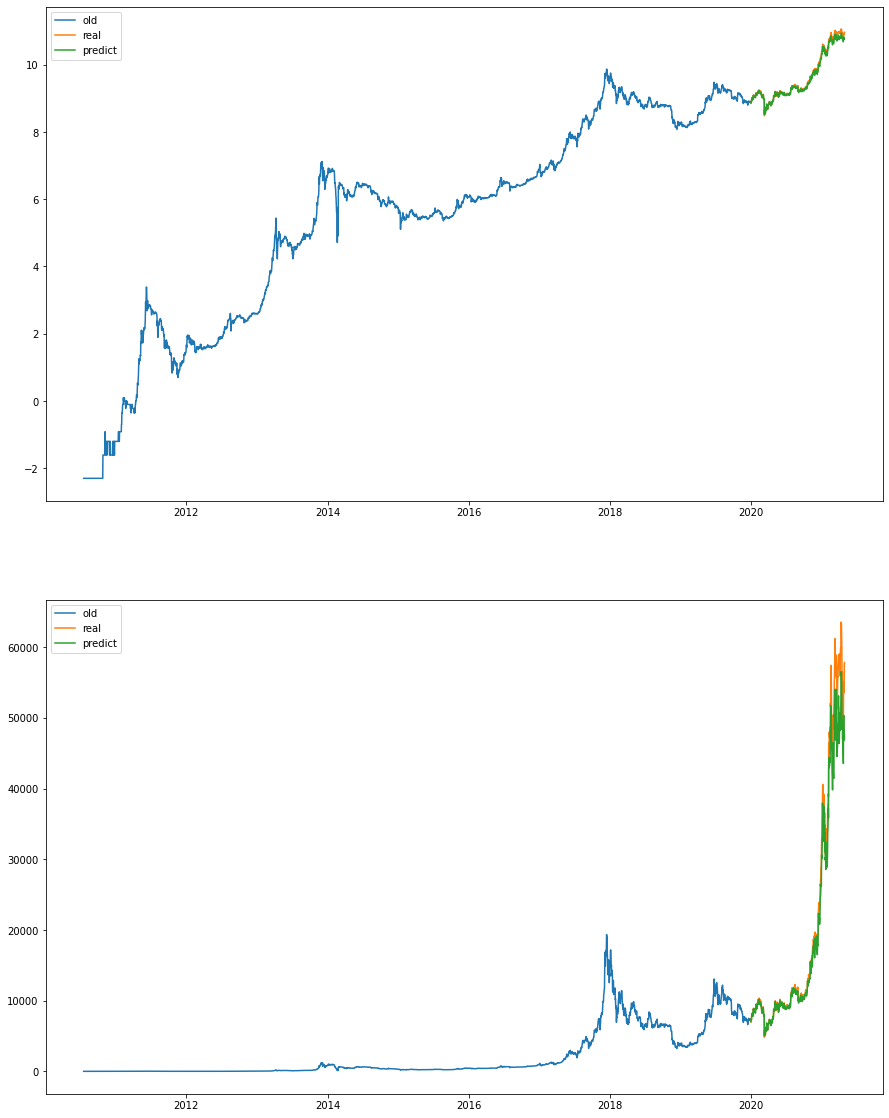

In [7]:
min_max_scaler1 = MinMaxScaler()
min_max_scaler2 = MinMaxScaler()

X_train = min_max_scaler1.fit_transform(DF_TRAIN[['Price', 'Num News']].to_numpy())
y_train = min_max_scaler2.fit_transform(DF_TRAIN['Price'].to_numpy().reshape(-1,1))

X_train = X_train[0:len(X_train)-1]
y_train = y_train[1:len(y_train)]

X_train = np.reshape(X_train, (-1, 2, 1))

testing_set = min_max_scaler1.transform(DF_TEST[['Price', 'Num News']].to_numpy())
X_test = np.reshape(testing_set, (-1, 2, 1))


num_units = 10
activation_function = 'sigmoid'
optimizer = 'adam'
loss_function = 'mean_squared_error'
batch_size = 2
num_epochs = 100

regressor = Sequential()
regressor.add(LSTM(units = num_units, activation = activation_function, input_shape=(None, 1)))
regressor.add(Dense(units = 5))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = optimizer, loss = loss_function)
regressor.fit(X_train, y_train, batch_size = batch_size, epochs = num_epochs, verbose=2, validation_split=.1)

regpredict = regressor.predict(X_test)
y_pred = min_max_scaler2.inverse_transform(regpredict).flatten()
y_test = DF_TEST['Price'].to_numpy().flatten()

rmse = np.sqrt(((y_test - y_pred)**2).sum()/len(y_pred))
print('RMSE(log) = ', rmse)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(15,20))
minold=0
ax1.plot(DF_TRAIN['Date'][minold:], DF_TRAIN['Price'][minold:], label='old')
ax1.plot(DF_TEST['Date'],DF_TEST['Price'], label='real')
ax1.plot(DF_TEST['Date'], y_pred, label='predict')
ax1.legend()


rmse = np.sqrt(((np.exp(y_test) - np.exp(y_pred))**2).sum()/len(y_pred))
print('RMSE(real) = ', rmse)

ax2.plot(DF_TRAIN['Date'][minold:], np.exp(DF_TRAIN['Price'][minold:]), label='old')
ax2.plot(DF_TEST['Date'],np.exp(DF_TEST['Price']), label='real')
ax2.plot(DF_TEST['Date'], np.exp(y_pred), label='predict')
ax2.legend()

p = 0.05
real = np.exp(y_test)
pred = np.exp(y_pred)

s = np.logical_and((real*(1-p)) <= pred, pred <= (real*(1+p))).sum()
print('Accuracy real',s/len(real))

Epoch 1/100
1554/1554 - 5s - loss: 0.0288 - val_loss: 0.0140
Epoch 2/100
1554/1554 - 3s - loss: 0.0010 - val_loss: 7.3564e-04
Epoch 3/100
1554/1554 - 3s - loss: 9.9203e-05 - val_loss: 1.8077e-05
Epoch 4/100
1554/1554 - 3s - loss: 7.3257e-05 - val_loss: 1.8338e-04
Epoch 5/100
1554/1554 - 3s - loss: 7.9857e-05 - val_loss: 4.2809e-05
Epoch 6/100
1554/1554 - 3s - loss: 7.1943e-05 - val_loss: 3.1095e-05
Epoch 7/100
1554/1554 - 3s - loss: 7.2410e-05 - val_loss: 5.1815e-05
Epoch 8/100
1554/1554 - 3s - loss: 6.7915e-05 - val_loss: 3.1836e-05
Epoch 9/100
1554/1554 - 3s - loss: 6.8945e-05 - val_loss: 6.8823e-05
Epoch 10/100
1554/1554 - 3s - loss: 6.8022e-05 - val_loss: 1.0349e-05
Epoch 11/100
1554/1554 - 3s - loss: 7.0962e-05 - val_loss: 1.9937e-05
Epoch 12/100
1554/1554 - 3s - loss: 6.4366e-05 - val_loss: 6.0332e-05
Epoch 13/100
1554/1554 - 3s - loss: 6.9494e-05 - val_loss: 2.2466e-05
Epoch 14/100
1554/1554 - 3s - loss: 6.3439e-05 - val_loss: 2.6769e-05
Epoch 15/100
1554/1554 - 3s - loss: 6.544

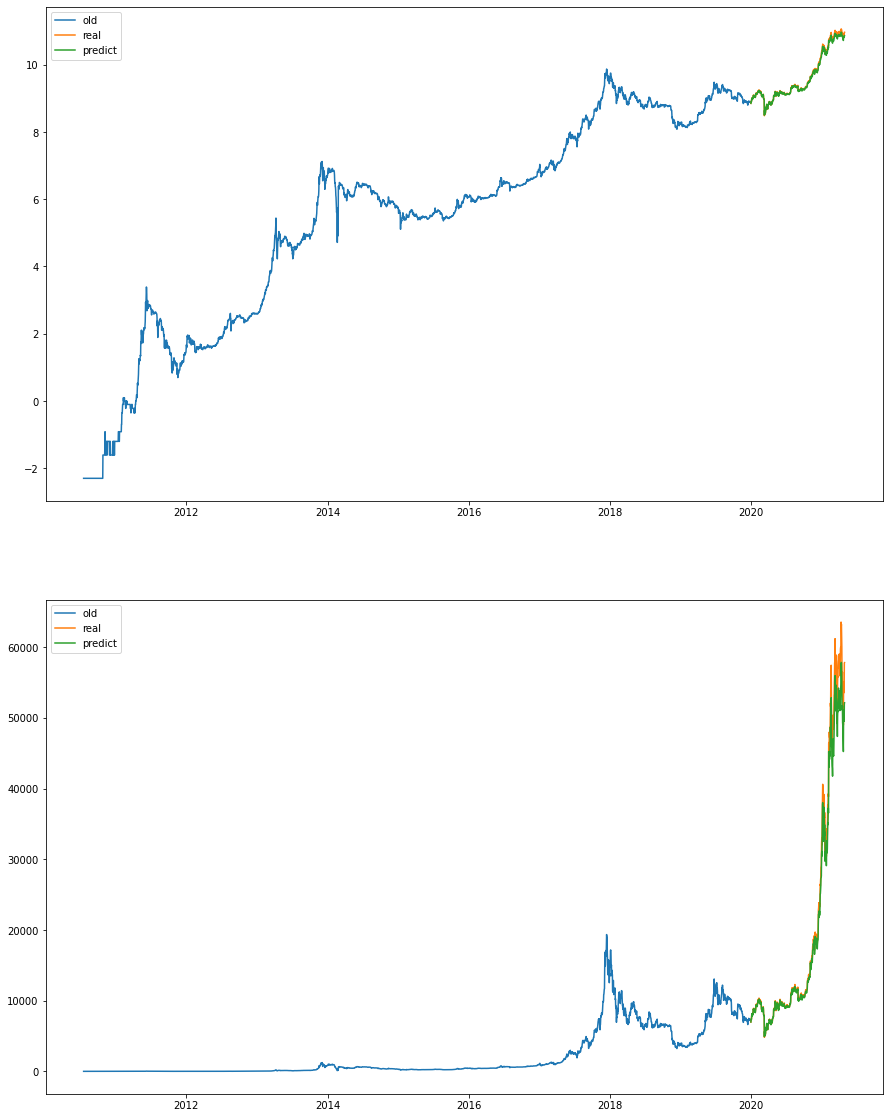

In [8]:
min_max_scaler1 = MinMaxScaler()
min_max_scaler2 = MinMaxScaler()
X_train = min_max_scaler1.fit_transform(DF_TRAIN[['Price', 'Num News']].to_numpy().reshape(-1,2))
y_train = min_max_scaler2.fit_transform(DF_TRAIN['Price'].to_numpy().reshape(-1,1))

X_train = X_train[0:len(X_train)-1]
y_train = y_train[1:len(y_train)]

X_train = np.reshape(X_train, (-1, 1, 2))

testing_set = min_max_scaler1.transform(DF_TEST[['Price', 'Num News']].to_numpy().reshape(-1,2))
X_test = np.reshape(testing_set, (-1, 1, 2))


num_units = 10
activation_function = 'sigmoid'
optimizer = 'adam'
loss_function = 'mean_squared_error'
batch_size = 2
num_epochs = 100

regressor = Sequential()
regressor.add(LSTM(units = num_units, activation = activation_function, input_shape=(None, 2)))
regressor.add(Dense(units = 5))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = optimizer, loss = loss_function)
regressor.fit(X_train, y_train, batch_size = batch_size, epochs = num_epochs, verbose=2, validation_split=.1)

regpredict = regressor.predict(X_test)
y_pred = min_max_scaler2.inverse_transform(regpredict).flatten()
y_test = DF_TEST['Price'].to_numpy().flatten()


rmse = np.sqrt(((y_test - y_pred)**2).sum()/len(y_pred))
print('RMSE(log) = ', rmse)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(15,20))
minold=0
ax1.plot(DF_TRAIN['Date'][minold:], DF_TRAIN['Price'][minold:], label='old')
ax1.plot(DF_TEST['Date'],DF_TEST['Price'], label='real')
ax1.plot(DF_TEST['Date'], y_pred, label='predict')
ax1.legend()


rmse = np.sqrt(((np.exp(y_test) - np.exp(y_pred))**2).sum()/len(y_pred))
print('RMSE(real) = ', rmse)

ax2.plot(DF_TRAIN['Date'][minold:], np.exp(DF_TRAIN['Price'][minold:]), label='old')
ax2.plot(DF_TEST['Date'],np.exp(DF_TEST['Price']), label='real')
ax2.plot(DF_TEST['Date'], np.exp(y_pred), label='predict')
ax2.legend()

p = 0.05
real = np.exp(y_test)
pred = np.exp(y_pred)

s = np.logical_and((real*(1-p)) <= pred, pred <= (real*(1+p))).sum()
print('Accuracy real',s/len(real))

RMSE(log) =  0.0009844544810540933
RMSE(real) =  12.36817086479673
Accuracy real 1.0


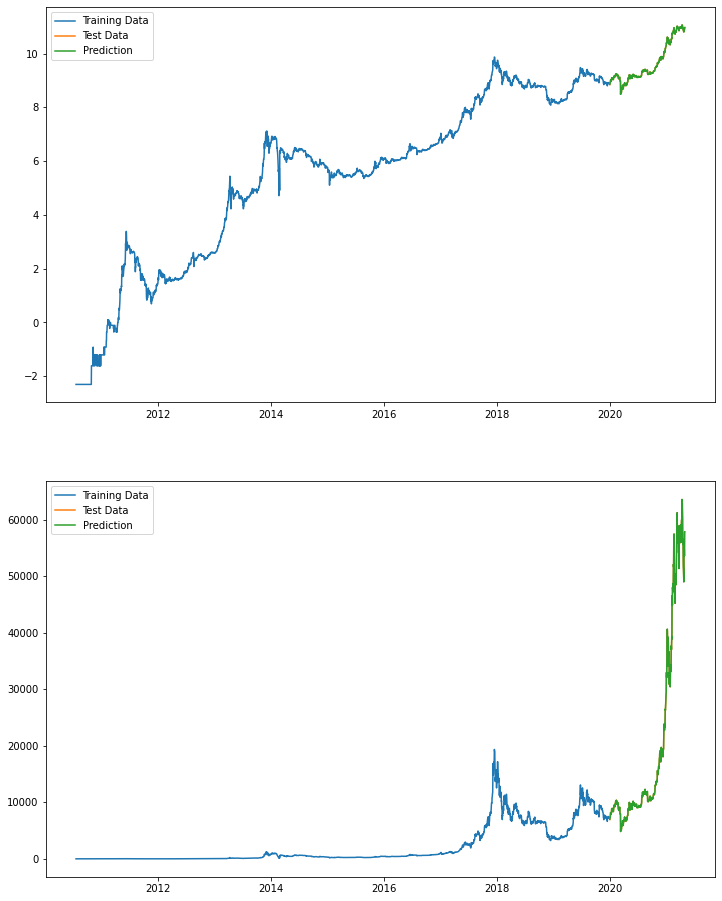

In [9]:
from sklearn.neural_network import MLPRegressor


min_max_scaler1 = MinMaxScaler()
min_max_scaler2 = MinMaxScaler()

X_train = min_max_scaler1.fit_transform(DF_TRAIN['Price'].to_numpy().reshape(-1,1))
y_train = min_max_scaler2.fit_transform(DF_TRAIN['Price'].to_numpy().reshape(-1,1))

X_train = X_train[0:len(X_train)-1]
y_train = y_train[1:len(y_train)].flatten()

X_test = min_max_scaler1.transform(DF_TEST['Price'].to_numpy().reshape(-1,1))



mdl = MLPRegressor((3),solver='lbfgs',random_state=6)
mdl.fit(X_train,y_train)

regpredict = mdl.predict(X_test)
y_pred = min_max_scaler2.inverse_transform(regpredict.reshape(-1,1)).flatten()

y_test = DF_TEST['Price'].to_numpy().flatten()

rmse = np.sqrt(((y_test - y_pred)**2).sum()/len(y_pred))
print('RMSE(log) = ', rmse)

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,16))
minold=0
ax1.plot(DF_TRAIN['Date'][minold:], DF_TRAIN['Price'][minold:], label='Training Data')
ax1.plot(DF_TEST['Date'],DF_TEST['Price'], label='Test Data')
ax1.plot(DF_TEST['Date'], y_pred, label='Prediction')
ax1.legend()


rmse = np.sqrt(((np.exp(y_test) - np.exp(y_pred))**2).sum()/len(y_pred))
print('RMSE(real) = ', rmse)

ax2.plot(DF_TRAIN['Date'][minold:], np.exp(DF_TRAIN['Price'][minold:]), label='Training Data')
ax2.plot(DF_TEST['Date'],np.exp(DF_TEST['Price']), label='Test Data')
ax2.plot(DF_TEST['Date'], np.exp(y_pred), label='Prediction')
ax2.legend()

p = 0.05
real = np.exp(y_test)
pred = np.exp(y_pred)

s = np.logical_and((real*(1-p)) <= pred, pred <= (real*(1+p))).sum()
print('Accuracy real',s/len(real))

RMSE(log) =  0.0041621794870043
RMSE(real) =  50.854182948083135
Accuracy real 1.0


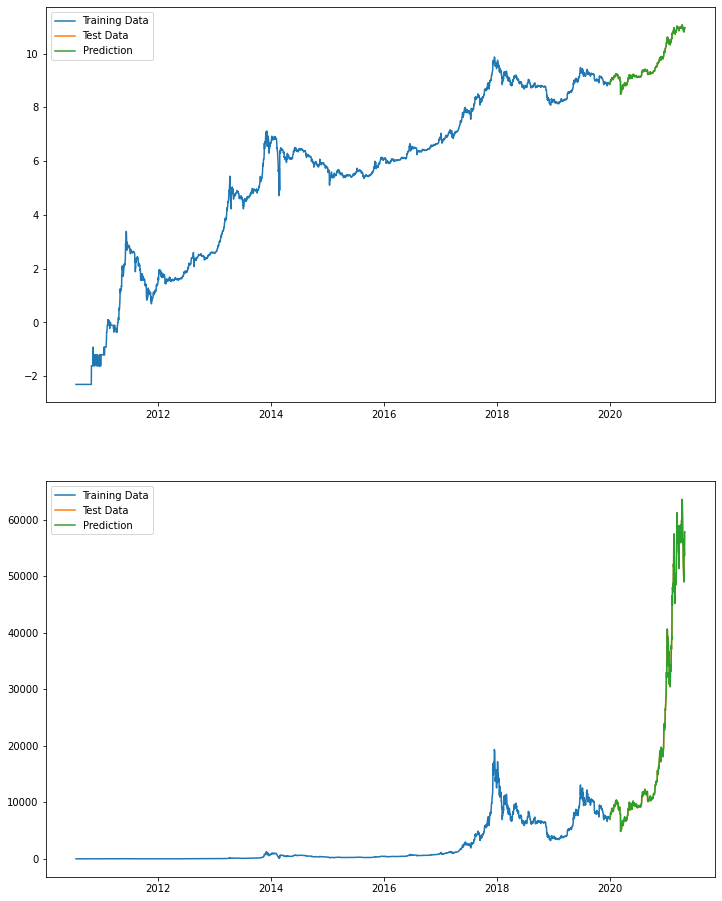

In [10]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

min_max_scaler1 = MinMaxScaler()
min_max_scaler2 = MinMaxScaler()

X_train = min_max_scaler1.fit_transform(DF_TRAIN['Price'].to_numpy().reshape(-1,1))
y_train = min_max_scaler2.fit_transform(DF_TRAIN['Price'].to_numpy().reshape(-1,1))

X_train = X_train[0:len(X_train)-1]
y_train = y_train[1:len(y_train)].flatten()

X_test = min_max_scaler1.transform(DF_TEST['Price'].to_numpy().reshape(-1,1))



# mdl = AdaBoostRegressor(DecisionTreeRegressor())
mdl = AdaBoostRegressor(LinearRegression())
mdl.fit(X_train,y_train)

regpredict = mdl.predict(X_test)
y_pred = min_max_scaler2.inverse_transform(regpredict.reshape(-1,1)).flatten()

y_test = DF_TEST['Price'].to_numpy().flatten()

rmse = np.sqrt(((y_test - y_pred)**2).sum()/len(y_pred))
print('RMSE(log) = ', rmse)

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,16))
minold=0
ax1.plot(DF_TRAIN['Date'][minold:], DF_TRAIN['Price'][minold:], label='Training Data')
ax1.plot(DF_TEST['Date'],DF_TEST['Price'], label='Test Data')
ax1.plot(DF_TEST['Date'], y_pred, label='Prediction')
ax1.legend()


rmse = np.sqrt(((np.exp(y_test) - np.exp(y_pred))**2).sum()/len(y_pred))
print('RMSE(real) = ', rmse)

ax2.plot(DF_TRAIN['Date'][minold:], np.exp(DF_TRAIN['Price'][minold:]), label='Training Data')
ax2.plot(DF_TEST['Date'],np.exp(DF_TEST['Price']), label='Test Data')
ax2.plot(DF_TEST['Date'], np.exp(y_pred), label='Prediction')
ax2.legend()

p = 0.05
real = np.exp(y_test)
pred = np.exp(y_pred)

s = np.logical_and((real*(1-p)) <= pred, pred <= (real*(1+p))).sum()
print('Accuracy real',s/len(real))

RMSE(log) =  0.4752265826990193
RMSE(real) =  15547.910850321929
Accuracy real 0.6131687242798354


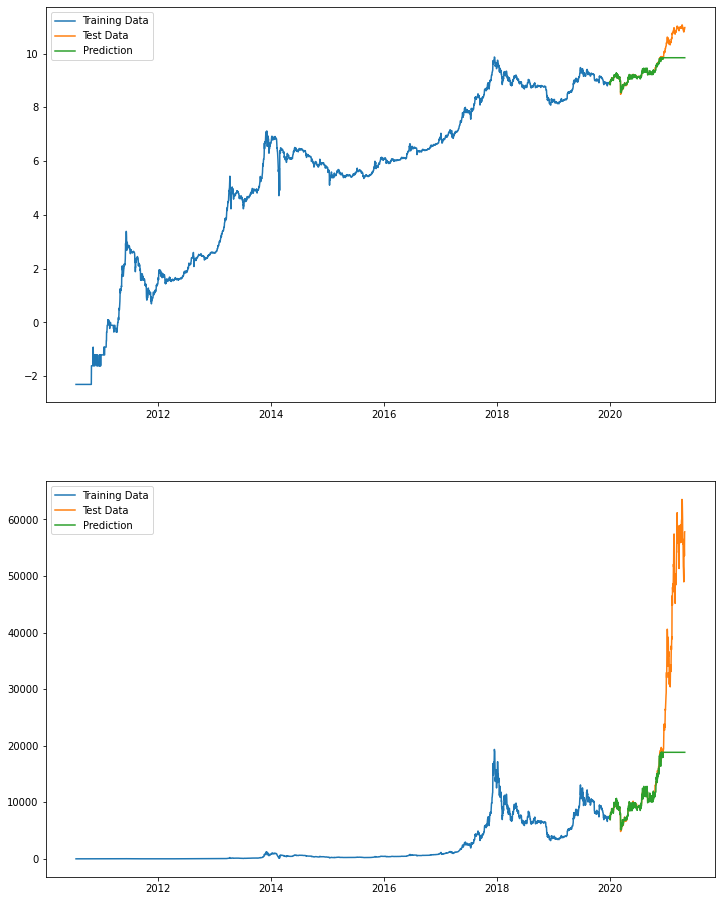

In [11]:
from sklearn.ensemble import RandomForestRegressor

min_max_scaler1 = MinMaxScaler()
min_max_scaler2 = MinMaxScaler()

X_train = min_max_scaler1.fit_transform(DF_TRAIN['Price'].to_numpy().reshape(-1,1))
y_train = min_max_scaler2.fit_transform(DF_TRAIN['Price'].to_numpy().reshape(-1,1))

X_train = X_train[0:len(X_train)-1]
y_train = y_train[1:len(y_train)].flatten()

X_test = min_max_scaler1.transform(DF_TEST['Price'].to_numpy().reshape(-1,1))



mdl = RandomForestRegressor()
mdl.fit(X_train,y_train)

regpredict = mdl.predict(X_test)
y_pred = min_max_scaler2.inverse_transform(regpredict.reshape(-1,1)).flatten()

y_test = DF_TEST['Price'].to_numpy().flatten()

rmse = np.sqrt(((y_test - y_pred)**2).sum()/len(y_pred))
print('RMSE(log) = ', rmse)

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,16))
minold=0
ax1.plot(DF_TRAIN['Date'][minold:], DF_TRAIN['Price'][minold:], label='Training Data')
ax1.plot(DF_TEST['Date'],DF_TEST['Price'], label='Test Data')
ax1.plot(DF_TEST['Date'], y_pred, label='Prediction')
ax1.legend()


rmse = np.sqrt(((np.exp(y_test) - np.exp(y_pred))**2).sum()/len(y_pred))
print('RMSE(real) = ', rmse)

ax2.plot(DF_TRAIN['Date'][minold:], np.exp(DF_TRAIN['Price'][minold:]), label='Training Data')
ax2.plot(DF_TEST['Date'],np.exp(DF_TEST['Price']), label='Test Data')
ax2.plot(DF_TEST['Date'], np.exp(y_pred), label='Prediction')
ax2.legend()

p = 0.05
real = np.exp(y_test)
pred = np.exp(y_pred)

s = np.logical_and((real*(1-p)) <= pred, pred <= (real*(1+p))).sum()
print('Accuracy real',s/len(real))